In [1]:
%matplotlib inline
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tnrange, tqdm_notebook,tqdm
import math
import random
from PIL import Image
import os
from collections import OrderedDict

# Preprocess

In [2]:
DataDir = './'
SAPARATELINE = '-' * 98 # the lens is same as github
SAPARATE = lambda: print(SAPARATELINE)
data = pd.read_csv('train.csv')

print("The shape of 'train.csv': ",data.shape)
SAPARATE()
print("The head of 'train.csv':\n",data.head())

The shape of 'train.csv':  (5711, 9)
--------------------------------------------------------------------------------------------------
The head of 'train.csv':
    Unnamed: 0  id                        left                        right  \
0           0   0  Data/01.90+/00000_left.jpg  Data/01.90+/00000_right.jpg   
1           1   1  Data/01.90+/00001_left.jpg  Data/01.90+/00001_right.jpg   
2           2   2  Data/01.90+/00002_left.jpg  Data/01.90+/00002_right.jpg   
3           3   3  Data/01.90+/00003_left.jpg  Data/01.90+/00003_right.jpg   
4           6   6  Data/01.90+/00006_left.jpg  Data/01.90+/00006_right.jpg   

                         top label                     left_box  \
0  Data/01.90+/00000_top.jpg   90+  ['142', '37', '563', '431']   
1  Data/01.90+/00001_top.jpg   90+   ['93', '35', '555', '442']   
2  Data/01.90+/00002_top.jpg   90+  ['100', '59', '548', '437']   
3  Data/01.90+/00003_top.jpg   90+   ['89', '67', '520', '433']   
4  Data/01.90+/00006_top.jpg   90+

In [3]:
random_index = np.random.randint(0,data.index.size)
# print('Label:\t',data['label'][random_index])

random_apple_info = data.loc[random_index]
img_left_pos = random_apple_info['left_box'][2:-2].split("', '")
img_top_pos = random_apple_info['top_box'][2:-2].split("', '")
img_right_pos = random_apple_info['right_box'][2:-2].split("', '")

print('Label:\t',data['label'][random_index])
print('Left:\t{:30}\tPos: ({:3},{:3}),({:3},{:3})'
      .format(random_apple_info.at['left'],
              img_left_pos[0],img_left_pos[1],
              img_left_pos[2],img_left_pos[3]))
print('Top:\t{:30}\tPos: ({:3},{:3}),({:3},{:3})'
      .format(random_apple_info.at['top'],
              img_top_pos[0],img_top_pos[1],
              img_top_pos[2],img_top_pos[3]))
print('Right:\t{:30}\tPos: ({:3},{:3}),({:3},{:3})'
      .format(random_apple_info.at['right'],
              img_right_pos[0],img_right_pos[1],
              img_right_pos[2],img_right_pos[3]))


Label:	 bad
Left:	Data/04.bad/00105_left.jpg    	Pos: (98 ,83 ),(403,345)
Top:	Data/04.bad/00105_top.jpg     	Pos: (157,199),(437,444)
Right:	Data/04.bad/00105_right.jpg   	Pos: (199,125),(510,405)


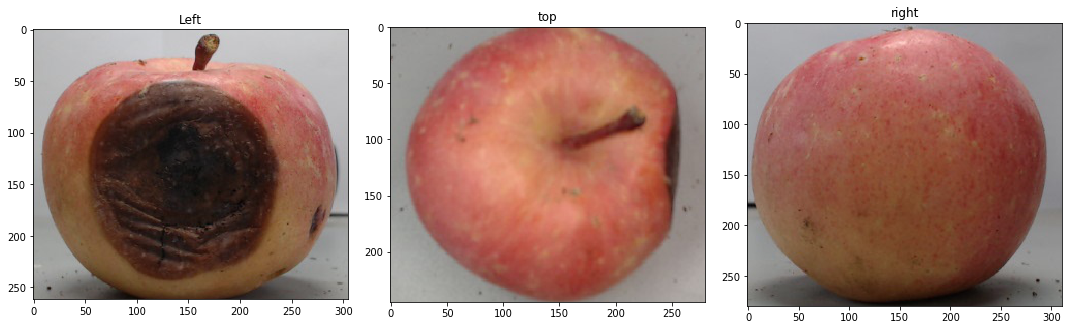

In [4]:
pil_img_left = Image.open(os.path.join(DataDir, random_apple_info.at['left']))
pil_img_left = pil_img_left.crop((int(img_left_pos[0]),int(img_left_pos[1]),
                                  int(img_left_pos[2]),int(img_left_pos[3])))
pil_img_right = Image.open(os.path.join(DataDir, random_apple_info.at['right']))
pil_img_right = pil_img_right.crop((int(img_right_pos[0]),int(img_right_pos[1]),
                                    int(img_right_pos[2]),int(img_right_pos[3])))
pil_img_top = Image.open(os.path.join(DataDir, random_apple_info.at['top']))
pil_img_top = pil_img_top.crop((int(img_top_pos[0]),int(img_top_pos[1]),
                                int(img_top_pos[2]),int(img_top_pos[3])))

# pil_im = Image.open('1.jpg').convert('L') #灰度操作

plt.figure(figsize=(5 * 3 , 5))

ax1 = plt.subplot('131')
plt.imshow(pil_img_left)
ax1.set_title("Left")

ax2 = plt.subplot(132)
plt.imshow(pil_img_top)
ax2.set_title("top")

ax3 = plt.subplot(133)
plt.imshow(pil_img_right)
ax3.set_title("right")

plt.tight_layout()
plt.show()

In [5]:
print('Labels: ', sorted(set(data['label'])))

Labels:  ['80+', '80-', '90+', 'bad']


In [6]:
# data[["id", "label"]].groupby(['label'], as_index=False)
print("Count the amount of each label:")
pd.value_counts(data["label"])

Count the amount of each label:


90+    2907
80+    1967
80-     441
bad     396
Name: label, dtype: int64

## Get mean and std of every channal

This is only a example, just show how to get mean and std from one picture.

**Notice: In training phase, your mean and std must calculate from the whole training set.**

In [7]:
pic = np.array(pil_img_left)
print("pic.shape:",pic.shape)

pic_mean = np.mean(pic/255, axis = (0,1),keepdims = True)
print("pic_mean:",pic_mean)

pic_mean = pic_mean.reshape(3,)
print("pic_mean:", pic_mean)

pic_std = np.std(pic,axis = (0,1),keepdims = True)
print("pic_std:",pic_std)

pic_std = pic_std.reshape(3,)
print("pic_std:",pic_std)


pic.shape: (262, 305, 3)
pic_mean: [[[0.4864052  0.38608327 0.34705215]]]
pic_mean: [0.4864052  0.38608327 0.34705215]
pic_std: [[[60.17899054 61.28892634 65.43322674]]]
pic_std: [60.17899054 61.28892634 65.43322674]


In [8]:
def line_chart(x,y,x_label,y_labal,tital,color):
    plt.plot(x,y,color,linewidth=1)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
    plt.xlabel(x_label)                  #X轴标签
    plt.ylabel(y_labal)                        #Y轴标签
    plt.title(tital)                #图标题
    plt.show()

# start 

In [9]:
class AppleSet(Dataset):
    
    def __init__(self, root, train = True, transform = None, ):
        self.train = train
        self.root = root
        self.transform = transform
#         classes = ['90+','80+','80-','bad']
        if self.train:
            self.data = pd.read_csv(os.path.join(self.root, 'train.csv' ))
            print(pd.value_counts(self.data["label"]))
        else:
            self.data = pd.read_csv(os.path.join(self.root, 'test.csv' ))
            print(pd.value_counts(self.data["label"]))
                    
    def __len__(self):
        return self.data.index.size

    def __getitem__(self, index):
        self.classes = ['90+','80+','80-','bad']
        
        data_item          = self.data.iloc[index]
        apple_item_path    = data_item['left']
        apple_item_img     = Image.open(os.path.join(self.root, apple_item_path))
        apple_img_box_list = data_item['left_box'][2:-2].split("', '")
        apple_item_img     = apple_item_img.crop((int(apple_img_box_list[0]),
                                                  int(apple_img_box_list[1]),
                                                  int(apple_img_box_list[2]),
                                                  int(apple_img_box_list[3])))
        
        if self.transform:
            apple_item_img = self.transform(apple_item_img)
        target = data_item['label']

        return apple_item_img, self.classes.index(target),data_item['id'],data_item['label']


In [10]:
N_CLASSES  = 4
IMAGE_SIZE = 227
BATCH_SIZE = 16

use_cuda = torch.cuda.is_available()
if (use_cuda):
    print("Great, you have a GPU!")
else:
    print("Life is short -- consider a GPU!")
device = torch.device("cuda:2" if use_cuda else "cpu")
print('Your device will be: ', device)  

Great, you have a GPU!
Your device will be:  cuda:2


In [11]:
transform = transforms.Compose([
#     transforms.CenterCrop(480), #???
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(), #???
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_data = AppleSet(root = DataDir, train = True, transform = transform)
test_data = AppleSet(root = DataDir, train = False, transform = transform)
print(len(train_data))
print(len(test_data))

90+    2907
80+    1967
80-     441
bad     396
Name: label, dtype: int64
90+    738
80+    497
80-    118
bad     75
Name: label, dtype: int64
5711
1428


In [12]:
print('Train Size: ', train_data.data.size)

Train Size:  51399


In [13]:
# train_data.data

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size = BATCH_SIZE)


tensor([0, 3, 0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0])


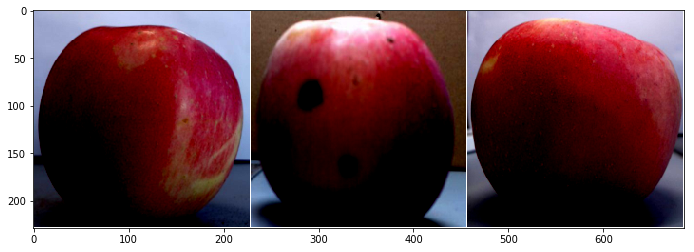

In [15]:
def imshow(batch, class_names=None, num_images=4):
    plt.figure(figsize=(4 * num_images, 4))
    img, classes,ids,labels = batch
    print(classes)
    img_num = min(num_images, img.shape[0])

    grid = torchvision.utils.make_grid(img[:img_num], 
                                       nrow=img_num, 
                                       padding = 1,
                                      pad_value = 1)
    grid = grid.cpu().numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    
    plt.imshow(grid)
#     if class_names:
#         titles = [class_names[x] for x in classes[:img_num]]
#         plt.axis('off')
#         plt.title(titles)
    plt.pause(0.001)
    
imshow(next(iter(train_loader)),num_images = 3)   

In [16]:
torch.manual_seed(117)

## Create Model

In [17]:
class Net(nn.Module):
    def __init__(self, num_classes = 4, init_weights = True, pretrained = True):
        super(Net, self).__init__()
        self.conv = torch.nn.Sequential(OrderedDict([
            ('Conv2d_1',nn.Conv2d(3, 64, 11, 4, 2)),
            ('ReLU_1',nn.ReLU(inplace = True)),
            ('MaxPool2d_1',nn.MaxPool2d(3, 2, 0)),
            ('Conv2d_2',nn.Conv2d(64, 192, 5, 1, 2)),
            ('ReLU_2',nn.ReLU(inplace=True)),
            ('MaxPool2d_2',nn.MaxPool2d(3, 2, 0)),
            ('Conv2d_3',nn.Conv2d(192, 384, 3, 1, 1)),
            ('ReLU_3',nn.ReLU(inplace = True)),
            ('Conv2d_4',nn.Conv2d(384, 256, 3, 1, 1)),
            ('ReLU_4',nn.ReLU(inplace=True)),
            ('Conv2d_5',nn.Conv2d(256,256 ,3, 1, 1)),
            ('ReLU_5',nn.ReLU(inplace=True)),
            ('MaxPool2d_3',nn.MaxPool2d(3, 2, 0))
        ]))

        self.dense = torch.nn.Sequential(OrderedDict([
            ('Dropout_1',nn.Dropout()),
            ('Linear_1',nn.Linear(9216, 4096)),
            ('ReLU_1',nn.ReLU(inplace=True)),
            ('Dropout_2',nn.Dropout()),
            ('Linear_2',nn.Linear(4096, 4096)),
            ('ReLU_2',nn.ReLU(inplace=True)),
            ('Linear_3',nn.Linear(4096, num_classes))
          ]))
        
        if init_weights:
            self._initialize_weights()
            
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()      
        

## Create a function to return a pre-trained model

In [18]:
def AppleModel(pretrained = False, **kwargs):
    model = Net(**kwargs)
    if pretrained:
        print("Try to use pre-trained model")
        filePath = os.path.join(DataDir, 'AppleModel.pth')
        if os.path.isfile(filePath):
            print("Loading...")
            model = torch.load(filePath)
            print("Success!")
        else:
            print("Failed! Create a new model instead.")
    return model

## Create Train Function

In [19]:
def train(model, device, train_loader, optimizer, epoch):
    SAPARATE()
    print("Start training...")
    print('epoch: {}, Learning rate: {}'.format(epoch,optimizer.param_groups[0]['lr']))
    model.train()
    
    correct = 0
    total_loss = 0
    total_acc = 0
    train_list = {'loss':[],'acc':[],'idx':[]}
    global train_list_global
    
    tqdm_loader = tqdm_notebook(train_loader,total=len(train_loader))
    for batch_idx, (inputs, targets,ids,labels) in enumerate(tqdm_loader):
        indx_target = targets.clone() # clone labels
        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.to(device), targets.to(device)
            
        optimizer.zero_grad()   # Clears the gradients of all optimized
        outputs = model(inputs) # output will be batch_size * class_size
        
        loss = F.cross_entropy(outputs, targets) # calculate loss 
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data.item() # add loss to total_loss
        
        pred = outputs.data.max(1)[1]  # get the index of the max log-probability
        correct = pred.cpu().eq(indx_target).sum()
        total_acc += correct # the amount of corrent items
        
        if batch_idx % 5 == 0 and batch_idx >= 0:
                acc = float(correct) * 1.0 / len(inputs) * 100
                train_list['loss'].append(loss.data.item())
                train_list['acc'].append(acc)
                train_list['idx'].append(batch_idx)
#                 print('Train Epoch: {} [{:5}/{:5}] Loss: {:.6f} Acc: {:.4f} lr: {:.2e}'.
#                       format(epoch,
#                              batch_idx * len(inputs),
#                              len(train_loader.dataset),
#                              loss.data.item(),
#                              acc,
#                              optimizer.param_groups[0]['lr']))

    print("Train Info: Loss: {:.6f}, Acc: {:.6f}, lr: {:.2e}".
          format(total_loss,
                 100 * float(total_acc)/len(train_loader.dataset),
                 optimizer.param_groups[0]['lr']))
    train_list_global['loss'].append(total_loss)
    train_list_global['acc'].append(100 * float(total_acc)/len(train_loader.dataset))
    train_list_global['idx'].append(epoch)
    train_list_global['lr'].append(optimizer.param_groups[0]['lr'])
    # losss pic 
#     plt.plot(train_list['idx'],
#              train_list['loss'],
#              "b",linewidth=1,
#              label = "epoch_" + str(epoch))   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
#     plt.xlabel("iterations")                  #X轴标签
#     plt.ylabel("loss")                        #Y轴标签
#     plt.title("Lost Analysis")                #图标题
#     plt.show()
    line_chart(train_list['idx'],train_list['loss'],"iterations","loss",
               "Lost Analysis",'r')
    
    #acc pic
#     plt.plot(train_list['idx'],
#              train_list['acc'],
#              "r",linewidth=1,
#              label = "epoch_" + str(epoch))   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
#     plt.xlabel("iterations")                  #X轴标签
#     plt.ylabel("acc")                         #Y轴标签
#     plt.title("Accuracy Analysis")            #图标题
#     plt.show()
    line_chart(train_list['idx'],train_list['acc'],"iterations","loss",
               "Accuracy Analysis","b")

## Create Test Function

In [20]:
def test(model, device, test_loader, optimizer, epoch):
    model.eval()
    
    test_loss = 0
    correct = 0
    global best_acc
    global lr
    global patience
    global test_list_global
    
    tqdm_loader = tqdm_notebook(test_loader,total=len(test_loader))
    for batch_idx, (inputs, target,ids,labels) in enumerate(tqdm_loader):
        indx_target = target.clone()
        
        target = Variable(target)
        with torch.no_grad():
            inputs = Variable(inputs)
        
        if use_cuda:
            inputs, target = inputs.to(device), target.to(device)
            
        output = model(inputs)
        test_loss += F.cross_entropy(output, target).data.item()
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.cpu().eq(indx_target).sum()
#         test_loss_percent = test_loss / len(test_loader) # average over number of mini-batch
        acc = 100. * float(correct) / len(test_loader.dataset)
    
        
    print('Test set: Loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, 
        correct, 
        len(test_loader.dataset), 
        acc))

    test_list_global['loss'].append(test_loss)
    test_list_global['acc'].append(acc)
    test_list_global['idx'].append(epoch)
    test_list_global['lr'].append(optimizer.param_groups[0]['lr'])
    
    if acc > best_acc:
        save_file = True # config. If need to save model
        
        # if the acc of the model better than older one weo times, than update it.
        patience = patience + 1
        print("Best acc is {},lower than current acc {}. Patience set to {}.".
              format(best_acc,acc,patience))
        
        if patience == 2:
            patience = 0
            print("Patience already to 2,set to 0.")
            lr = lr/10
            print("Leaning Rate set to {}.".format(lr))
            
            if save_file: # model save
                new_file = os.path.join(DataDir, 'AppleModel.pth')
                torch.save(model, new_file)
                print("Save a new model to {}.".format(new_file))
            best_acc = acc 
            

## Create model

In [21]:
model = AppleModel(pretrained = True, num_classes = N_CLASSES, init_weights = True)
if use_cuda:
    model.to(device)
print(model)

Try to use pre-trained model
Loading...
Success!
Net(
  (conv): Sequential(
    (Conv2d_1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (ReLU_1): ReLU(inplace)
    (MaxPool2d_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (ReLU_2): ReLU(inplace)
    (MaxPool2d_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU_3): ReLU(inplace)
    (Conv2d_4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU_4): ReLU(inplace)
    (Conv2d_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (ReLU_5): ReLU(inplace)
    (MaxPool2d_3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (Dropout_1): Dropout(p=0.5)
    (Linear_1): Linear(in

## Strart Train model

Leaning Rate set to 0.001
--------------------------------------------------------------------------------------------------
Start training...
epoch: 0, Learning rate: 0.001



Train Info: Loss: 53.008574, Acc: 96.322886, lr: 1.00e-03


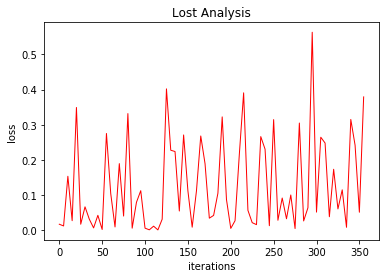

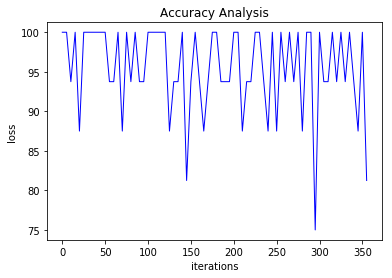


Test set: Loss: 14.6386, Accuracy: 1357/1428 (95.03%)
Best acc is 0,lower than current acc 95.0280112044818. Patience set to 1.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 1, Learning rate: 0.001



Train Info: Loss: 50.001444, Acc: 96.340396, lr: 1.00e-03


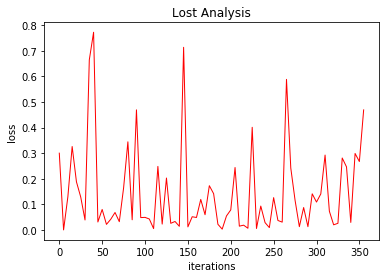

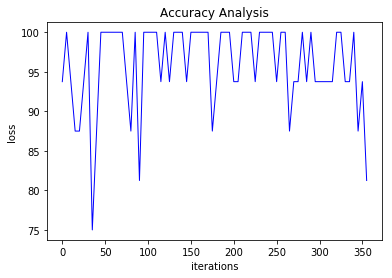


Test set: Loss: 11.9997, Accuracy: 1370/1428 (95.94%)
Best acc is 0,lower than current acc 95.93837535014005. Patience set to 2.
Patience already to 2,set to 0.
Leaning Rate set to 0.0001.


/lustre/wangdan/anaconda2/envs/py3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Save a new model to ./AppleModel.pth.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 2, Learning rate: 0.0001



Train Info: Loss: 24.782798, Acc: 97.811241, lr: 1.00e-04


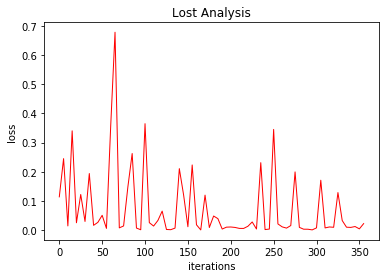

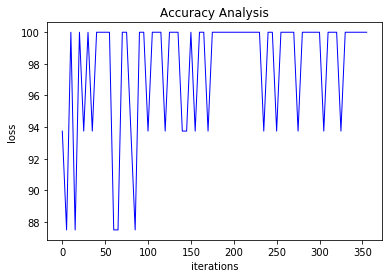


Test set: Loss: 8.4261, Accuracy: 1395/1428 (97.69%)
Best acc is 95.93837535014005,lower than current acc 97.6890756302521. Patience set to 1.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 3, Learning rate: 0.0001



Train Info: Loss: 17.983536, Acc: 98.476624, lr: 1.00e-04


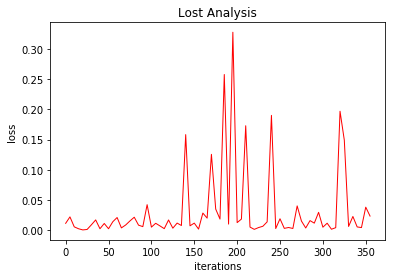

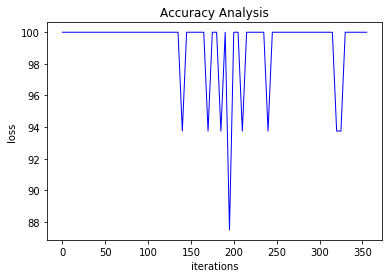


Test set: Loss: 10.3177, Accuracy: 1396/1428 (97.76%)
Best acc is 95.93837535014005,lower than current acc 97.75910364145658. Patience set to 2.
Patience already to 2,set to 0.
Leaning Rate set to 1e-05.


/lustre/wangdan/anaconda2/envs/py3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Save a new model to ./AppleModel.pth.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 4, Learning rate: 1e-05



Train Info: Loss: 13.625235, Acc: 98.861846, lr: 1.00e-05


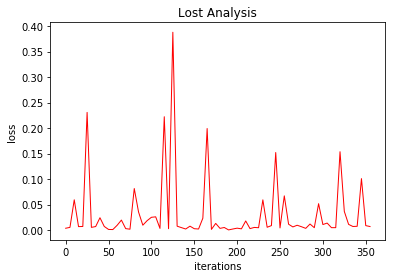

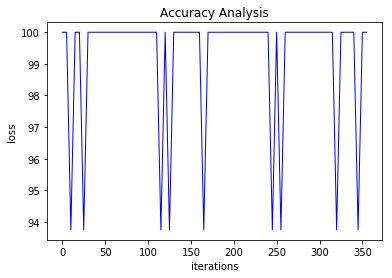


Test set: Loss: 10.5685, Accuracy: 1396/1428 (97.76%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 5, Learning rate: 1e-05



Train Info: Loss: 13.775540, Acc: 98.879356, lr: 1.00e-05


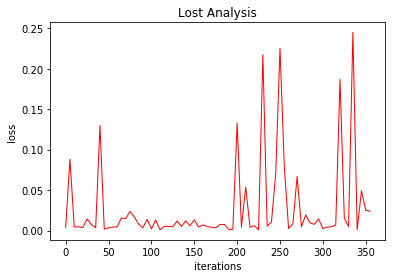

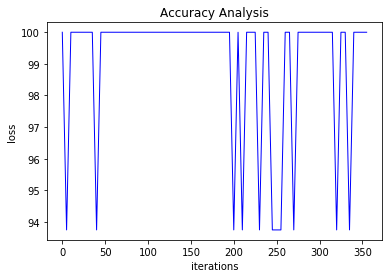


Test set: Loss: 9.9827, Accuracy: 1401/1428 (98.11%)
Best acc is 97.75910364145658,lower than current acc 98.10924369747899. Patience set to 1.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 6, Learning rate: 1e-05



Train Info: Loss: 12.189124, Acc: 98.984416, lr: 1.00e-05


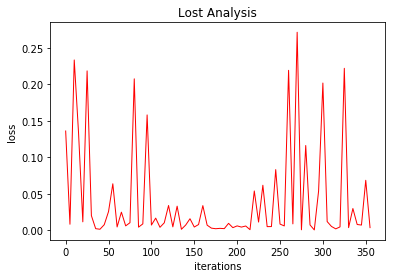

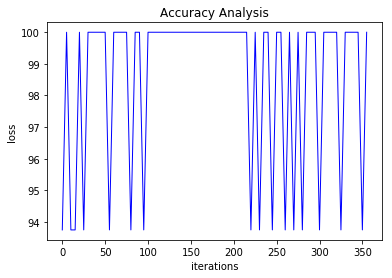


Test set: Loss: 11.8516, Accuracy: 1394/1428 (97.62%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 7, Learning rate: 1e-05



Train Info: Loss: 12.025548, Acc: 99.089476, lr: 1.00e-05


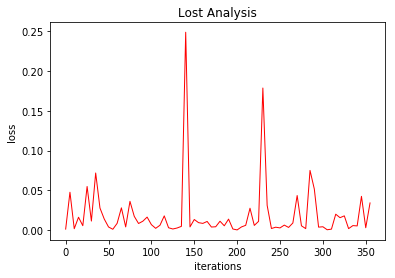

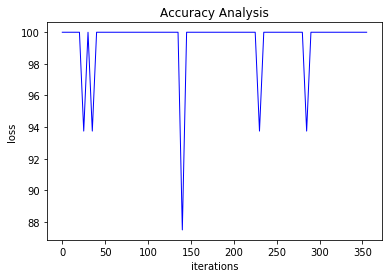


Test set: Loss: 8.7884, Accuracy: 1402/1428 (98.18%)
Best acc is 97.75910364145658,lower than current acc 98.17927170868347. Patience set to 2.
Patience already to 2,set to 0.
Leaning Rate set to 1.0000000000000002e-06.


/lustre/wangdan/anaconda2/envs/py3/lib/python3.7/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Save a new model to ./AppleModel.pth.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 8, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.560666, Acc: 99.089476, lr: 1.00e-06


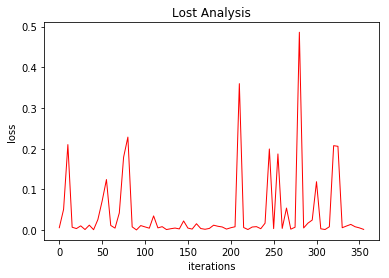

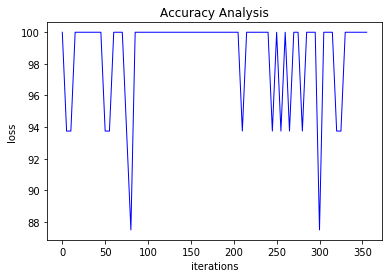


Test set: Loss: 10.8159, Accuracy: 1396/1428 (97.76%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 9, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 12.092394, Acc: 99.036946, lr: 1.00e-06


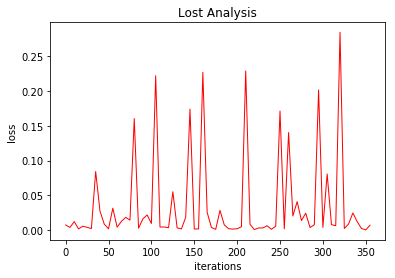

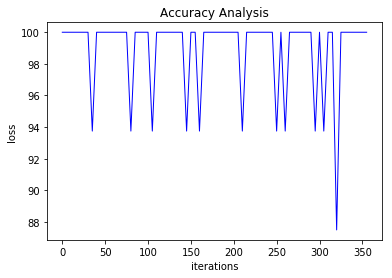


Test set: Loss: 11.8045, Accuracy: 1396/1428 (97.76%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 10, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.156310, Acc: 99.159517, lr: 1.00e-06


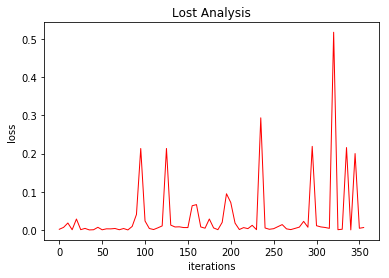

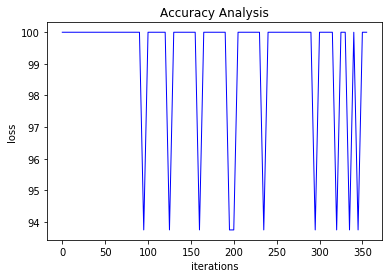


Test set: Loss: 9.2538, Accuracy: 1400/1428 (98.04%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 11, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.073025, Acc: 99.177027, lr: 1.00e-06


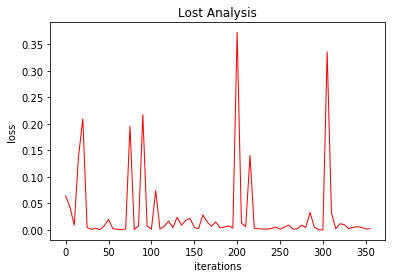

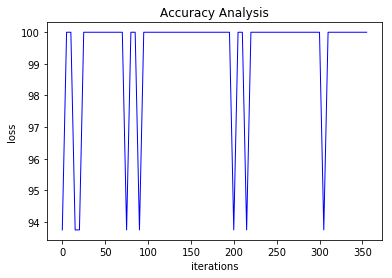


Test set: Loss: 10.5843, Accuracy: 1399/1428 (97.97%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 12, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.698438, Acc: 99.194537, lr: 1.00e-06


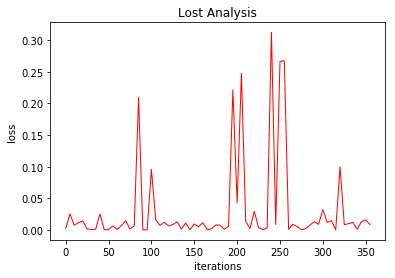

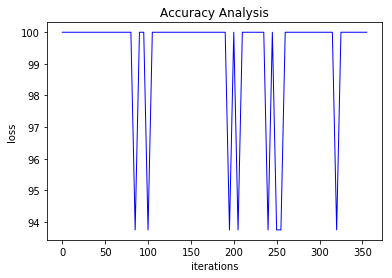


Test set: Loss: 9.5733, Accuracy: 1399/1428 (97.97%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 13, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.919019, Acc: 99.089476, lr: 1.00e-06


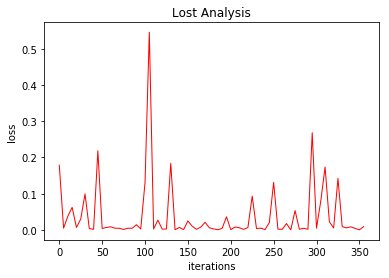

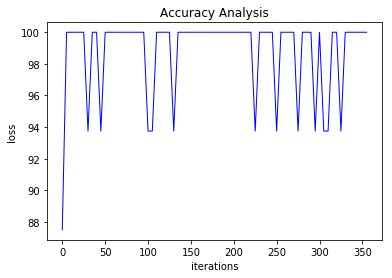


Test set: Loss: 9.0897, Accuracy: 1406/1428 (98.46%)
Best acc is 98.17927170868347,lower than current acc 98.4593837535014. Patience set to 1.
--------------------------------------------------------------------------------------------------
Start training...
epoch: 14, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.886118, Acc: 99.071966, lr: 1.00e-06


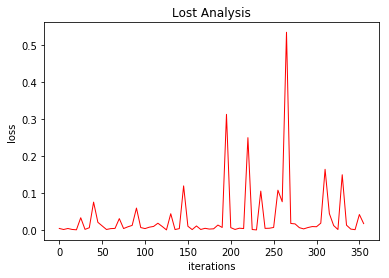

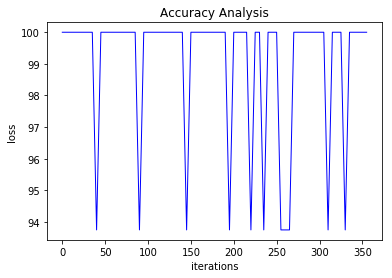


Test set: Loss: 10.5366, Accuracy: 1399/1428 (97.97%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 15, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.478872, Acc: 99.106987, lr: 1.00e-06


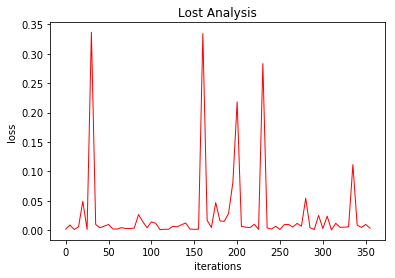

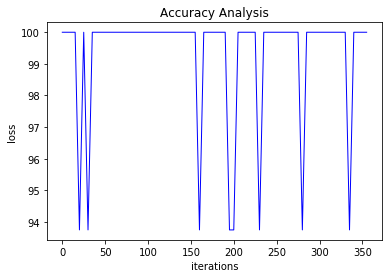


Test set: Loss: 9.9138, Accuracy: 1401/1428 (98.11%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 16, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.785508, Acc: 99.124497, lr: 1.00e-06


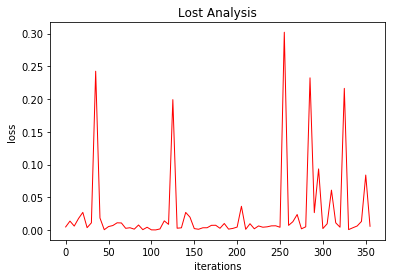

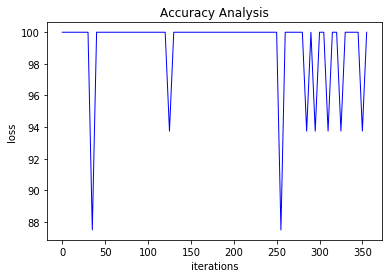


Test set: Loss: 11.2630, Accuracy: 1397/1428 (97.83%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 17, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 12.408360, Acc: 98.984416, lr: 1.00e-06


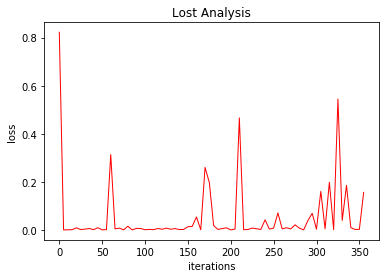

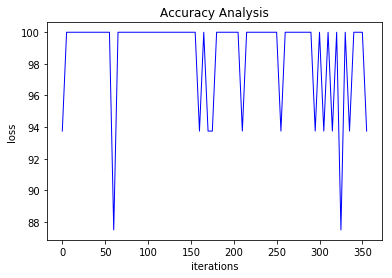


Test set: Loss: 9.5208, Accuracy: 1400/1428 (98.04%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 18, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.785467, Acc: 99.159517, lr: 1.00e-06


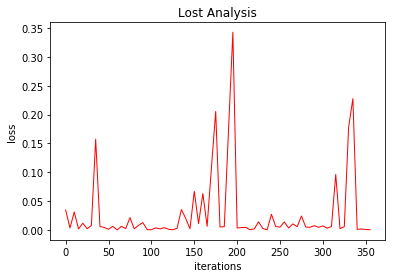

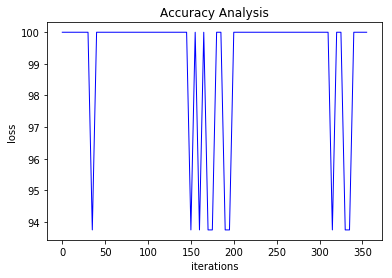


Test set: Loss: 11.1354, Accuracy: 1397/1428 (97.83%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 19, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.258493, Acc: 99.089476, lr: 1.00e-06


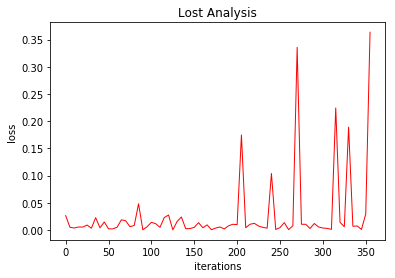

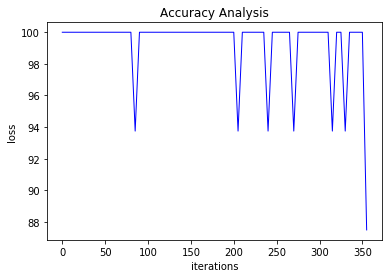


Test set: Loss: 10.0679, Accuracy: 1400/1428 (98.04%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 20, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.865104, Acc: 99.124497, lr: 1.00e-06


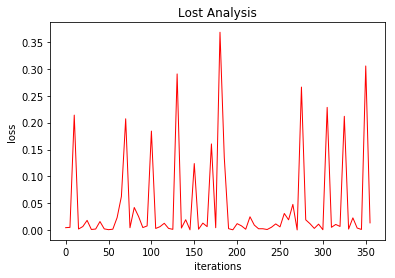

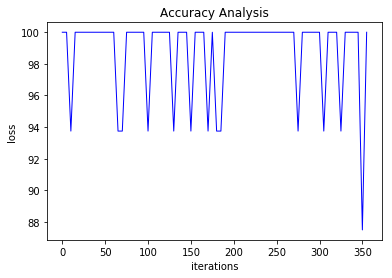


Test set: Loss: 12.6573, Accuracy: 1395/1428 (97.69%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 21, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.095863, Acc: 99.177027, lr: 1.00e-06


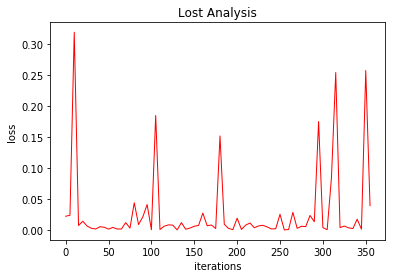

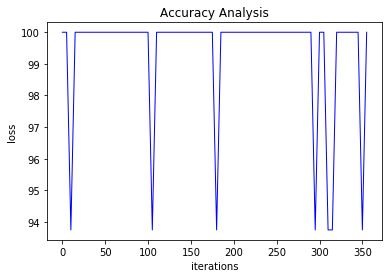


Test set: Loss: 11.2930, Accuracy: 1397/1428 (97.83%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 22, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.935051, Acc: 99.142007, lr: 1.00e-06


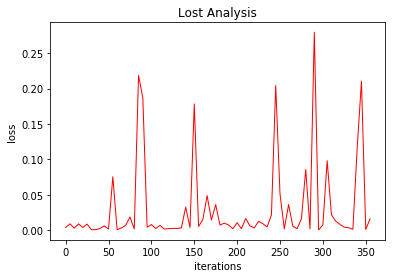

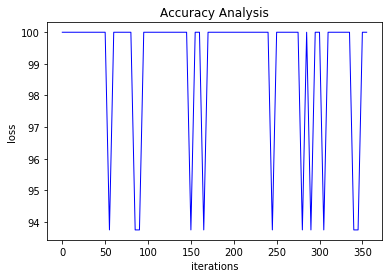


Test set: Loss: 12.0646, Accuracy: 1394/1428 (97.62%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 23, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.403026, Acc: 99.106987, lr: 1.00e-06


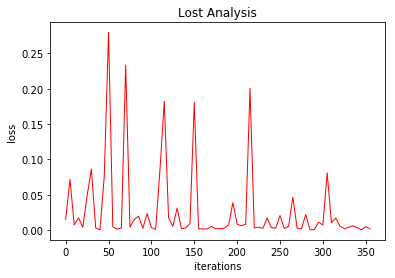

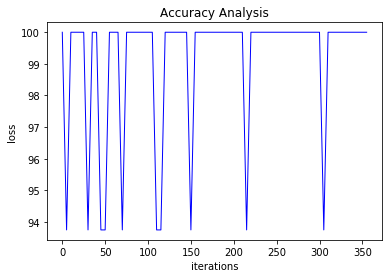


Test set: Loss: 10.3371, Accuracy: 1399/1428 (97.97%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 24, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.512051, Acc: 99.036946, lr: 1.00e-06


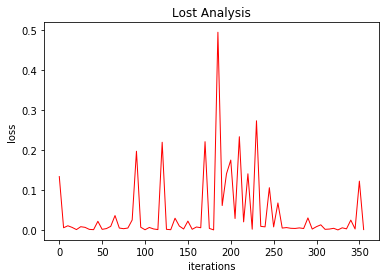

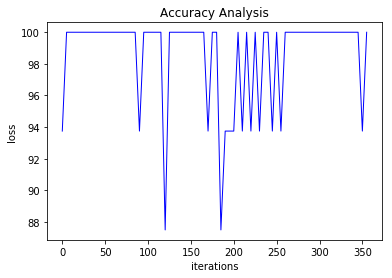


Test set: Loss: 11.9552, Accuracy: 1398/1428 (97.90%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 25, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.334925, Acc: 99.089476, lr: 1.00e-06


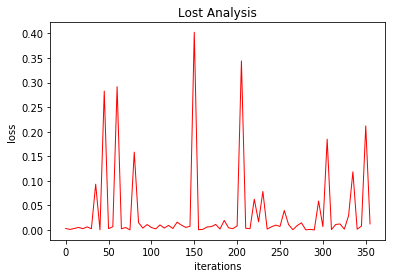

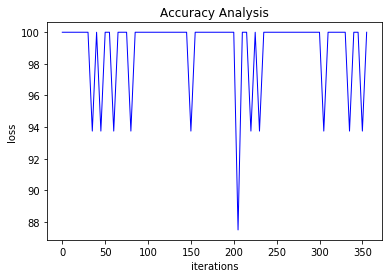


Test set: Loss: 11.3734, Accuracy: 1397/1428 (97.83%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 26, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.465269, Acc: 99.177027, lr: 1.00e-06


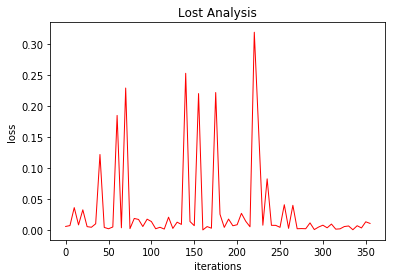

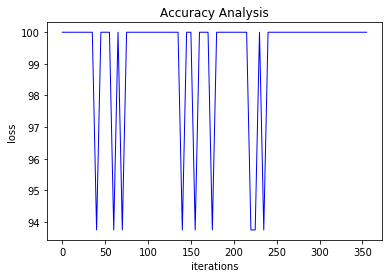


Test set: Loss: 10.1549, Accuracy: 1395/1428 (97.69%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 27, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 11.033789, Acc: 99.071966, lr: 1.00e-06


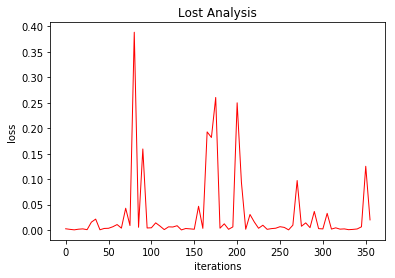

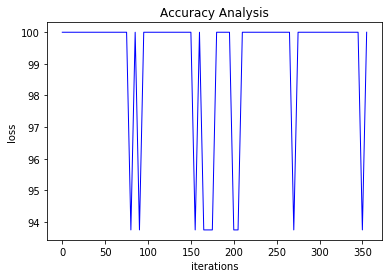


Test set: Loss: 11.9200, Accuracy: 1396/1428 (97.76%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 28, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 12.114507, Acc: 98.931886, lr: 1.00e-06


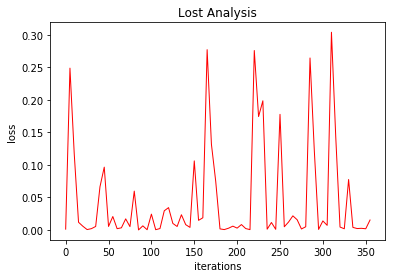

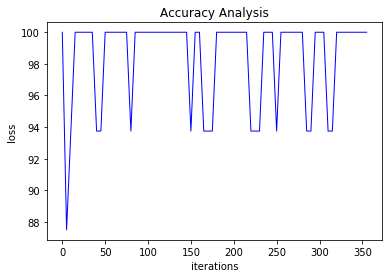


Test set: Loss: 12.0962, Accuracy: 1394/1428 (97.62%)
--------------------------------------------------------------------------------------------------
Start training...
epoch: 29, Learning rate: 1.0000000000000002e-06



Train Info: Loss: 10.783079, Acc: 99.106987, lr: 1.00e-06


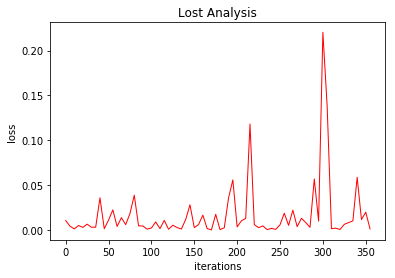

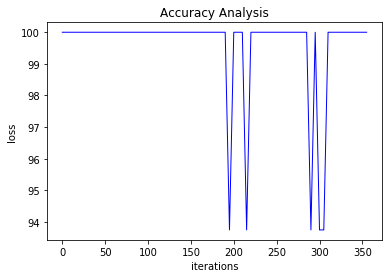


Test set: Loss: 10.9479, Accuracy: 1398/1428 (97.90%)
Best Result: 98.179%


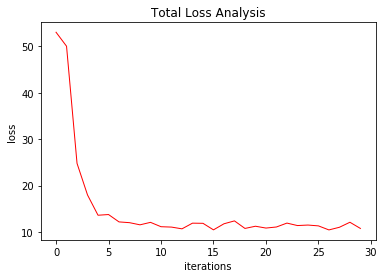

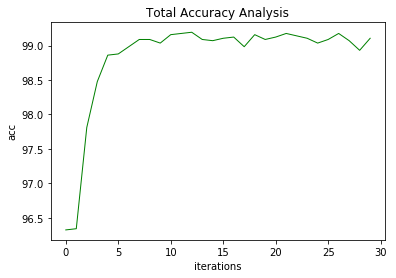

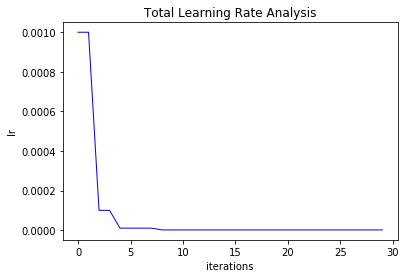

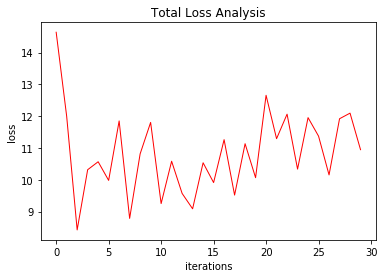

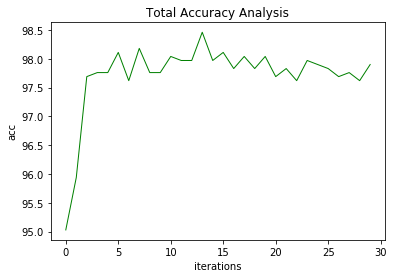

In [22]:
best_acc = 0
lr = 0
patience = 0
train_list_global = {'loss':[],'acc':[],'idx':[],'lr':[]}
test_list_global = {'loss':[],'acc':[],'idx':[],'lr':[]}
try:
    epoch_size = 30
    for epoch in range(epoch_size):
        if epoch == 0:
            lr = 0.001 # init learning rate
            print("Leaning Rate set to {}".format(lr))
        optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)
        
        train(model,device,train_loader,optimizer,epoch)
        test(model,device,test_loader,optimizer,epoch)
        
        torch.cuda.empty_cache()
except Exception as e:
    import traceback
    traceback.print_exc()
finally:
    print("Best Result: {:.3f}%".format(best_acc))
    
    line_chart(train_list_global['idx'],train_list_global['loss'],"iterations","loss",
               "Total Loss Analysis","r")
    line_chart(train_list_global['idx'],train_list_global['acc'],"iterations","acc",
               "Total Accuracy Analysis","g")
    line_chart(train_list_global['idx'],train_list_global['lr'],"iterations","lr",
               "Total Learning Rate Analysis","b")
    
    line_chart(test_list_global['idx'],test_list_global['loss'],"iterations","loss",
               "Total Loss Analysis","r")
    line_chart(test_list_global['idx'],test_list_global['acc'],"iterations","acc",
               "Total Accuracy Analysis","g")
    